## Import & Drive Mount

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import re

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
keras.__version__

'2.4.3'

In [ ]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/gender_data.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/gender_data.zip
  inflating: data/train/man/TM (1).jpg  
  inflating: data/train/man/TM (10).jpg  
  inflating: data/train/man/TM (100).jpg  
  inflating: data/train/man/TM (101).jpg  
  inflating: data/train/man/TM (102).jpg  
  inflating: data/train/man/TM (103).jpg  
  inflating: data/train/man/TM (104).jpg  
  inflating: data/train/man/TM (105).jpg  
  inflating: data/train/man/TM (106).jpg  
  inflating: data/train/man/TM (107).jpg  
  inflating: data/train/man/TM (108).jpg  
  inflating: data/train/man/TM (109).jpg  
  inflating: data/train/man/TM (11).jpg  
  inflating: data/train/man/TM (110).jpg  
  inflating: data/train/man/TM (111).jpg  
  inflating: data/train/man/TM (112).jpg  
  inflating: data/train/man/TM (113).jpg  
  inflating: data/train/man/TM (114).jpg  
  inflating: data/train/man/TM (115).jpg  
  inflating: data/train/man/TM (116).jpg  
  inflating: data/train/man/TM (117).jpg  
  inflating: data/train/man/TM (118

### data root 설정

In [ ]:
data_root_dir = 'data'
os.listdir(data_root_dir)

['train', 'valid']

In [ ]:
dir_names = [data_root_dir + child for child in ['/train/man', '/train/woman', '/valid/man', '/valid/woman']]

In [ ]:
# 확장자 명 확인
for check_dir in dir_names :
    print(f'- In "{check_dir}" directory : {os.listdir(check_dir)[:3]}')

- In "data/train/man" directory : ['136M.jpg', '702M.jpg', '11M.jpg']
- In "data/train/woman" directory : ['1695W.jpg', '1445W.jpg', '1109W.jpg']
- In "data/valid/man" directory : ['1843M.jpg', '2034M.jpg', '1792M.jpg']
- In "data/valid/woman" directory : ['2147W.jpg', '2070W.jpg', '2288W.jpg']


In [ ]:
train_dir = data_root_dir + '/train'
valid_dir = data_root_dir + '/valid'

print(f'- Train Directory : {train_dir}')
print(f'- Valid Directory  : {valid_dir}')

- Train Directory : data/train
- Valid Directory  : data/valid


In [ ]:
#데이터 개수 확인
train_man_dir = train_dir + '/man'
train_woman_dir = train_dir + '/woman'
valid_man_dir = valid_dir + '/man'
valid_woman_dir = valid_dir + '/woman'

print('* Train man Data')
print(f'==> {len(os.listdir(train_man_dir))}')

print('\n* Train woman Data')
print(f'==> {len(os.listdir(train_woman_dir))}')

print('\n* Validation man Data')
print(f'==> {len(os.listdir(valid_man_dir))}')

print('\n* Validation woman Data')
print(f'==> {len(os.listdir(valid_woman_dir))}')

* Train man Data
==> 739

* Train woman Data
==> 971

* Validation man Data
==> 330

* Validation woman Data
==> 440


### Generate Data

In [ ]:
#이미지 증강
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=90,
                               horizontal_flip = True,
                               vertical_flip = True
                               )


valid_gen = ImageDataGenerator(rescale = 1./255)


train_data = train_gen.flow_from_directory(train_dir,
                                           target_size = (200,200),
                                           batch_size = 100,
                                           class_mode = 'binary')

valid_data = valid_gen.flow_from_directory(valid_dir,
                                         target_size = (200,200),
                                         batch_size = 100,
                                         shuffle = False,
                                         class_mode = 'binary')

Found 1710 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


In [ ]:
print(f'- Train data : {len(train_data):4d} batches')
print(f'- Valid data  : {len(valid_data):4d} batches')

- Train data :   18 batches
- Valid data  :    8 batches


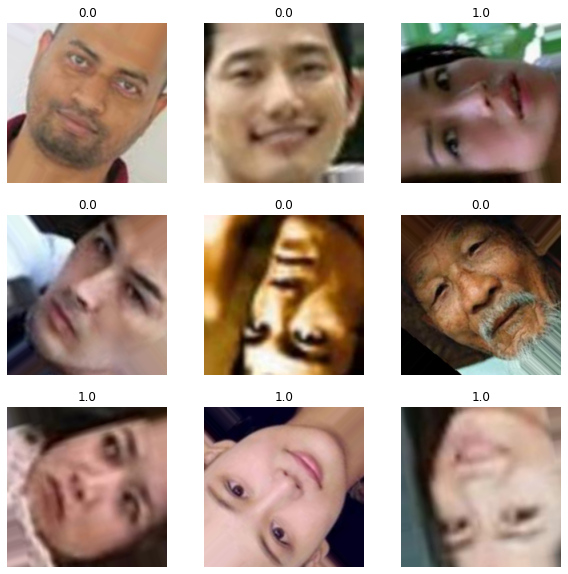

In [ ]:
#train data시각화 (0 : 남자 / 1 : 여자)
images = train_data[0][0][:9]
labels = train_data[0][1][:9]

plt.figure(figsize = (10,10))

for i in range(9) :
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis(False)

plt.show()

### test dataset


In [ ]:
!unzip /content/drive/My\ Drive/[양재]\ 1조/dataset/test.zip

Archive:  /content/drive/My Drive/[양재] 1조/dataset/test.zip
  inflating: test/desktop.ini        
  inflating: test/im (1).jpg         
  inflating: test/im (10).jpg        
  inflating: test/im (100).jpg       
  inflating: test/im (1000).jpg      
  inflating: test/im (1001).jpg      
  inflating: test/im (1002).jpg      
  inflating: test/im (1003).jpg      
  inflating: test/im (1004).jpg      
  inflating: test/im (1005).jpg      
  inflating: test/im (1006).jpg      
  inflating: test/im (1007).jpg      
  inflating: test/im (1008).jpg      
  inflating: test/im (1009).jpg      
  inflating: test/im (101).jpg       
  inflating: test/im (1010).jpg      
  inflating: test/im (1011).jpg      
  inflating: test/im (1012).jpg      
  inflating: test/im (1013).jpg      
  inflating: test/im (1014).jpg      
  inflating: test/im (1015).jpg      
  inflating: test/im (1016).jpg      
  inflating: test/im (1017).jpg      
  inflating: test/im (1018).jpg      
  inflating: test/im (1019).j

## define function

### loss & accuracy visualization

In [ ]:
def draw_graph(hist):
  plt.figure(figsize = (16,6))
  #loss
  plt.subplot(1,2,1)
  plt.plot(hist.epoch, hist.history['loss'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_loss'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train & Valid Loss')
  plt.legend()
  #accuracy
  plt.subplot(1,2,2)
  plt.plot(hist.epoch, hist.history['accuracy'], label = 'Train')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label = 'Valid')
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train & Valid Accuracy')
  plt.legend()

  plt.show()

### evaluate test data

In [ ]:
#test 파일 리스트업하기
import os

path = 'test/'
file_list = os.listdir(path)

In [ ]:
import cv2
import random

def sigmoid(x):
    return (1 / (1 +np.exp(-x))).astype(float)

def evaluate_testdata(model):

  plt.figure(figsize = (10, 16))

  #랜덤 난수 생성
  rn_list = random.sample(range(0,len(file_list)-1),5)

  for n in range(len(rn_list)):
    # 랜덤 이미지 경로 추출 
    image_path = 'test/' + file_list[rn_list[n]]

    # 이미지 출력 
    plt.subplot(5 , 2, n * 2 + 1) 
    plt.imshow(plt.imread(image_path)) 
    plt.axis('off')

    # 예측값 출력 공간 
    plt.subplot(5 , 2 , n * 2 + 2)

    # 이미지 크기 변경 및 정규화 
    img = cv2.imread(image_path) 
    img = cv2.resize(img, dsize = (200, 200)) 
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)

    #이미지 분류 
    logits = model.predict(img)[0]
    logit = logits.tolist()[0]
    pred = [(1 - logit) * 100, logit * 100]
    label = ['man','woman']

    #막대그래프 색상 지정 
    colors = ['green','yellow']
    
    # 막대그래프 출력 
    y = np.arange(2)
    plt.barh(y, pred, color = colors)
    plt.yticks(y, label) 
  plt.show()

## VGG16

### Modeling

In [ ]:
#import VGG16
from keras.applications import VGG16

conv_base = VGG16(#weights = 'imagenet',
                  include_top = False,
                  input_shape = (200, 200,3))

#model define
from keras import models, layers

#CNN-VGG16
model_V = models.Sequential()
model_V.add(conv_base)

#DNN
model_V.add(layers.Flatten())
model_V.add(layers.Dense(256, activation = 'relu'))
model_V.add(layers.Dropout(0.4))
model_V.add(layers.Dense(1, activation = 'sigmoid'))


model_V.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 19,433,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##Model Compile
from keras import optimizers

model_V.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

In [ ]:
##Model fit 
 
%%time

hist_V = model_V.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
18/18 [==============================] - 45s 1s/step - loss: 0.8225 - accuracy: 0.4992 - val_loss: 0.6169 - val_accuracy: 0.7065
Epoch 2/50
18/18 [==============================] - 18s 1s/step - loss: 0.6673 - accuracy: 0.6032 - val_loss: 0.5361 - val_accuracy: 0.7247
Epoch 3/50
18/18 [==============================] - 18s 1s/step - loss: 0.5536 - accuracy: 0.6973 - val_loss: 0.4903 - val_accuracy: 0.7584
Epoch 4/50
18/18 [==============================] - 18s 987ms/step - loss: 0.4936 - accuracy: 0.7457 - val_loss: 0.4233 - val_accuracy: 0.8026
Epoch 5/50
18/18 [==============================] - 18s 988ms/step - loss: 0.4271 - accuracy: 0.8075 - val_loss: 0.3839 - val_accuracy: 0.8416
Epoch 6/50
18/18 [==============================] - 18s 1s/step - loss: 0.3870 - accuracy: 0.8274 - val_loss: 0.3442 - val_accuracy: 0.8597
Epoch 7/50
18/18 [==============================] - 18s 986ms/step - loss: 0.3572 - accuracy: 0.8390 - val_loss: 0.4125 - val_accuracy: 0.8169
Epoch 8/50


### Evaluation

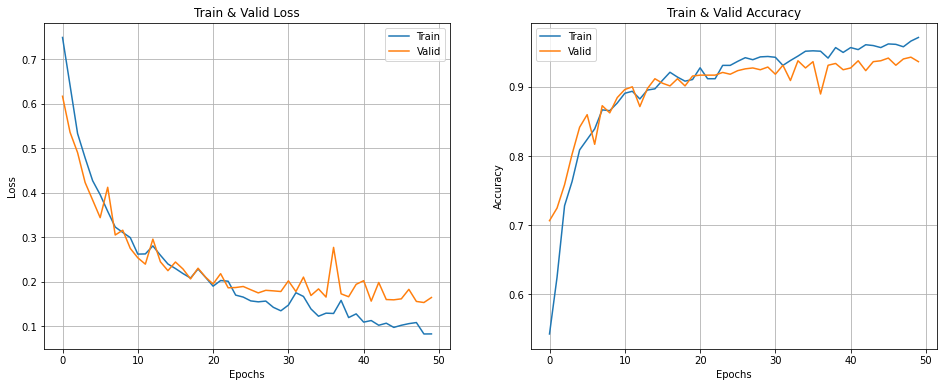

In [ ]:
draw_graph(hist_V)

In [ ]:
loss, acc_V = model_V.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V:.5f}')

8/8 [==============================] - 1s 148ms/step - loss: 0.1650 - accuracy: 0.9364

* Loss
==> 0.16496

* Accuracy
==> 0.93636


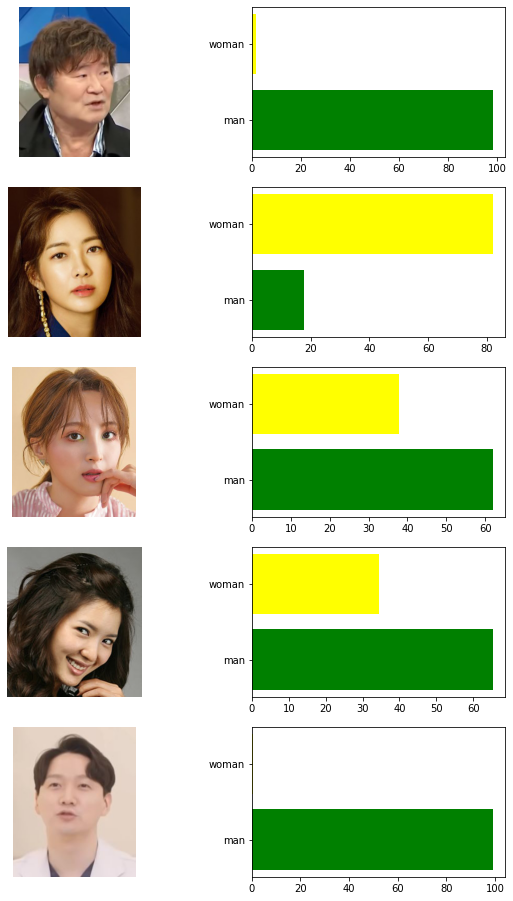

In [ ]:
evaluate_testdata(model_V)

## VGG19

### Modeling

In [ ]:
#import VGG19 
from keras.applications import VGG19

conv_base = VGG19(include_top = False,
                     #weights = 'imagenet',
                      input_shape = (200,200,3))

#model define
from keras import models, layers

#CNN-VGG19
model_V19 = models.Sequential()
model_V19.add(conv_base)

#DNN
model_V19.add(layers.Flatten())
model_V19.add(layers.Dense(256, activation = 'relu'))
model_V19.add(layers.Dropout(0.4))
model_V19.add(layers.Dense(1, activation = 'sigmoid'))


model_V19.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 24,743,489
Trainable params: 24,743,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##Model Compile
from keras import optimizers

model_V19.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

In [ ]:
##Model fit : epoch 조절

%%time

hist_V19 = model_V19.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
18/18 [==============================] - 23s 1s/step - loss: 0.6921 - accuracy: 0.5662 - val_loss: 0.5675 - val_accuracy: 0.7299
Epoch 2/50
18/18 [==============================] - 22s 1s/step - loss: 0.5603 - accuracy: 0.7311 - val_loss: 0.4784 - val_accuracy: 0.7740
Epoch 3/50
18/18 [==============================] - 22s 1s/step - loss: 0.5067 - accuracy: 0.7533 - val_loss: 0.4283 - val_accuracy: 0.8013
Epoch 4/50
18/18 [==============================] - 22s 1s/step - loss: 0.3914 - accuracy: 0.8263 - val_loss: 0.3749 - val_accuracy: 0.8299
Epoch 5/50
18/18 [==============================] - 22s 1s/step - loss: 0.3686 - accuracy: 0.8364 - val_loss: 0.3397 - val_accuracy: 0.8494
Epoch 6/50
18/18 [==============================] - 22s 1s/step - loss: 0.3329 - accuracy: 0.8493 - val_loss: 0.3249 - val_accuracy: 0.8597
Epoch 7/50
18/18 [==============================] - 22s 1s/step - loss: 0.3491 - accuracy: 0.8466 - val_loss: 0.3081 - val_accuracy: 0.8649
Epoch 8/50
18/18 [==

### Evaluation

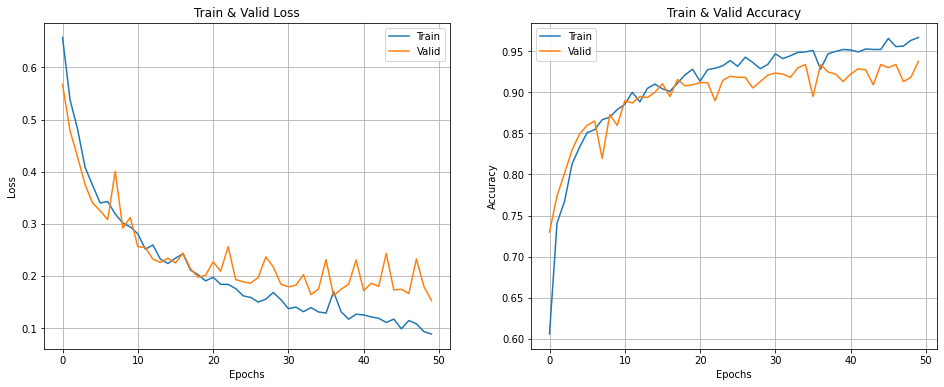

In [ ]:
draw_graph(hist_V19)

In [ ]:
loss, acc_V19 = model_V19.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss:.5f}')

print('\n* Accuracy')
print(f'==> {acc_V19:.5f}')


8/8 [==============================] - 2s 197ms/step - loss: 0.1526 - accuracy: 0.9377

* Loss
==> 0.15265

* Accuracy
==> 0.93766


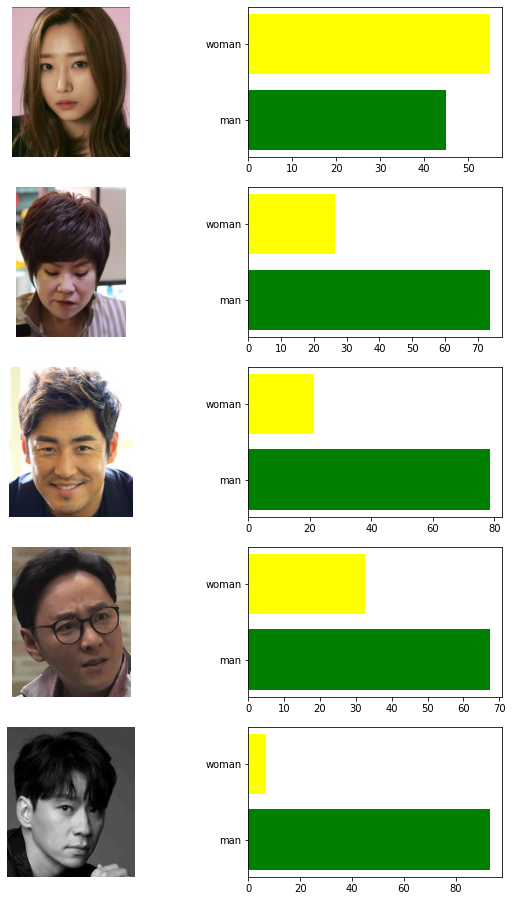

In [ ]:
evaluate_testdata(model_V)

## ResNet50

### Modeling

In [ ]:
#import ResNet50
from keras.applications.resnet50 import ResNet50

conv_base = ResNet50(include_top = False,
                       input_shape = (200,200,3))

#model define
from keras import models, layers

#CNN-ResNet50
model_R = models.Sequential()
model_R.add(conv_base)

#DNN
model_R.add(layers.Flatten())
model_R.add(layers.Dense(256, activation = 'relu'))
model_R.add(layers.Dropout(0.4))
model_R.add(layers.Dense(1, activation = 'sigmoid'))


model_R.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 49,278,337
Trainable params: 49,225,217
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
##Model Compile
from keras import optimizers

model_R.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

In [ ]:
##Model fit : epoch 조절

%%time

hist_R = model_R.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
18/18 [==============================] - 30s 1s/step - loss: 1.0383 - accuracy: 0.5654 - val_loss: 0.6836 - val_accuracy: 0.5714
Epoch 2/50
18/18 [==============================] - 21s 1s/step - loss: 0.5875 - accuracy: 0.7430 - val_loss: 0.7234 - val_accuracy: 0.5701
Epoch 3/50
18/18 [==============================] - 21s 1s/step - loss: 0.5536 - accuracy: 0.7624 - val_loss: 0.9072 - val_accuracy: 0.5701
Epoch 4/50
18/18 [==============================] - 21s 1s/step - loss: 0.4306 - accuracy: 0.8179 - val_loss: 1.0629 - val_accuracy: 0.5714
Epoch 5/50
18/18 [==============================] - 21s 1s/step - loss: 0.4447 - accuracy: 0.8045 - val_loss: 1.0615 - val_accuracy: 0.5714
Epoch 6/50
18/18 [==============================] - 21s 1s/step - loss: 0.4020 - accuracy: 0.8319 - val_loss: 1.2258 - val_accuracy: 0.5714
Epoch 7/50
18/18 [==============================] - 21s 1s/step - loss: 0.4061 - accuracy: 0.8095 - val_loss: 1.3193 - val_accuracy: 0.5714
Epoch 8/50
18/18 [==

### Evaluation

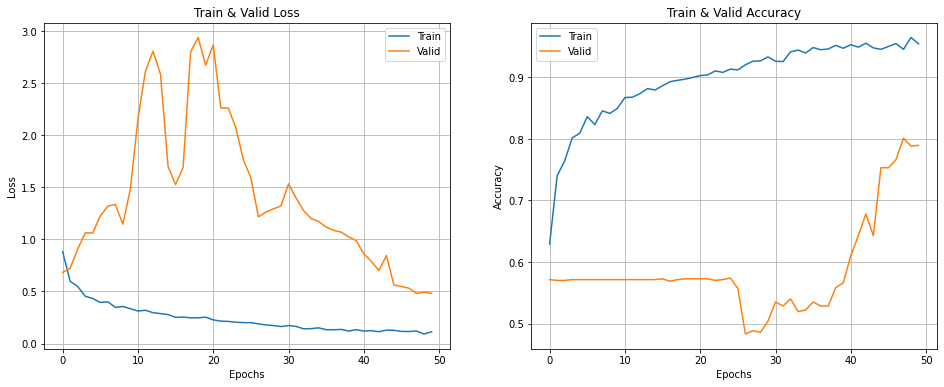

In [ ]:
draw_graph(hist_R)

In [ ]:
loss, acc_R = model_R.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R:.5f}')


8/8 [==============================] - 2s 178ms/step - loss: 0.4825 - accuracy: 0.7896

* Loss
==> 0.48253

* Accuracy
==> 0.78961


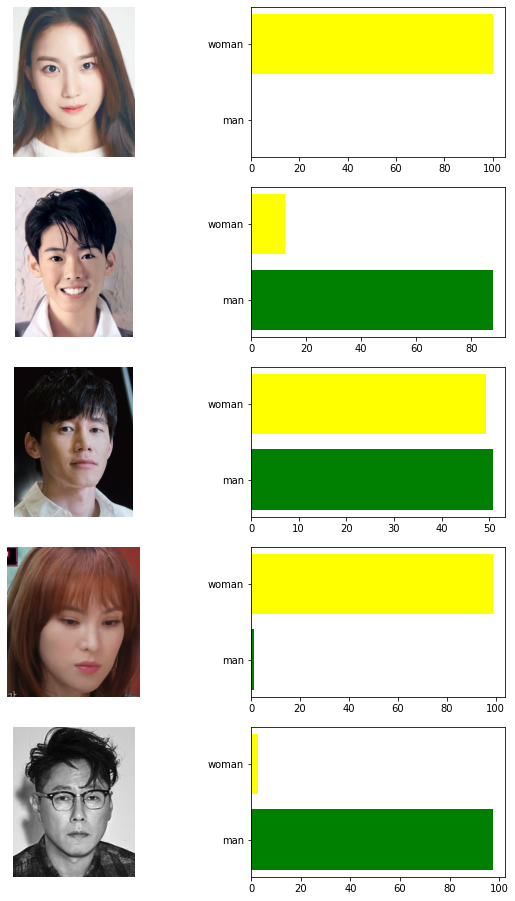

In [ ]:
evaluate_testdata(model_R)



## ResNet101

### Modeling

In [ ]:
#import ResNet101 
from keras.applications import ResNet101

conv_base = ResNet101(include_top = False,
                       input_shape = (200,200,3))

#model define
from keras import models, layers

#CNN-ResNet101
model_R101 = models.Sequential()
model_R101.add(conv_base)

#DNN
model_R101.add(layers.Flatten())
model_R101.add(layers.Dense(256, activation = 'relu'))
model_R101.add(layers.Dropout(0.4))
model_R101.add(layers.Dense(1, activation = 'sigmoid'))


model_R101.summary()

171450368/171446536 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 68,348,801
Trainable params: 68,243,457
Non-trainable params: 105,344
_________________________________________________________________


In [ ]:
##Model Compile
from keras import optimizers

model_R101.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

In [ ]:
##Model fit : epoch 조절

%%time

hist_R101 = model_R101.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
18/18 [==============================] - 39s 1s/step - loss: 0.9847 - accuracy: 0.5850 - val_loss: 1.0081 - val_accuracy: 0.5714
Epoch 2/50
18/18 [==============================] - 24s 1s/step - loss: 0.5988 - accuracy: 0.7378 - val_loss: 1.8260 - val_accuracy: 0.5714
Epoch 3/50
18/18 [==============================] - 24s 1s/step - loss: 0.5037 - accuracy: 0.7927 - val_loss: 2.9861 - val_accuracy: 0.5714
Epoch 4/50
18/18 [==============================] - 24s 1s/step - loss: 0.4364 - accuracy: 0.8161 - val_loss: 2.9557 - val_accuracy: 0.5714
Epoch 5/50
18/18 [==============================] - 24s 1s/step - loss: 0.4204 - accuracy: 0.8158 - val_loss: 4.3345 - val_accuracy: 0.5714
Epoch 6/50
18/18 [==============================] - 24s 1s/step - loss: 0.4225 - accuracy: 0.8134 - val_loss: 5.5258 - val_accuracy: 0.5714
Epoch 7/50
18/18 [==============================] - 24s 1s/step - loss: 0.3405 - accuracy: 0.8551 - val_loss: 5.6074 - val_accuracy: 0.5714
Epoch 8/50
18/18 [==

### Evaluation

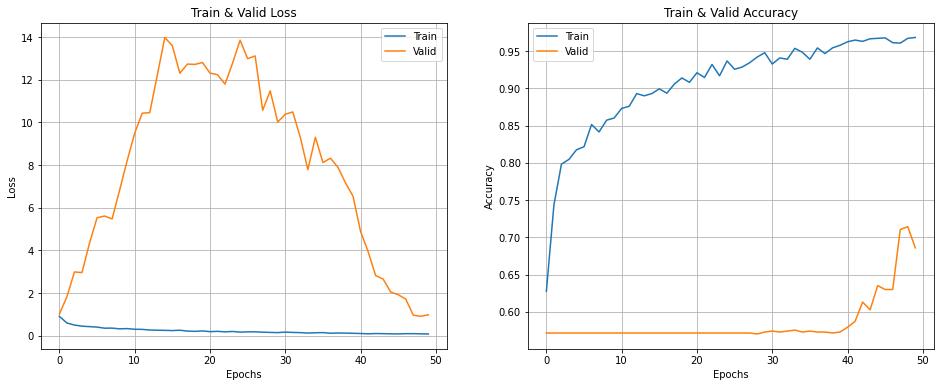

In [ ]:
draw_graph(hist_R101)

In [ ]:
loss, acc_R101 = model_R101.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R101:.5f}')


8/8 [==============================] - 2s 244ms/step - loss: 0.9787 - accuracy: 0.6857

* Loss
==> 0.97869

* Accuracy
==> 0.68571


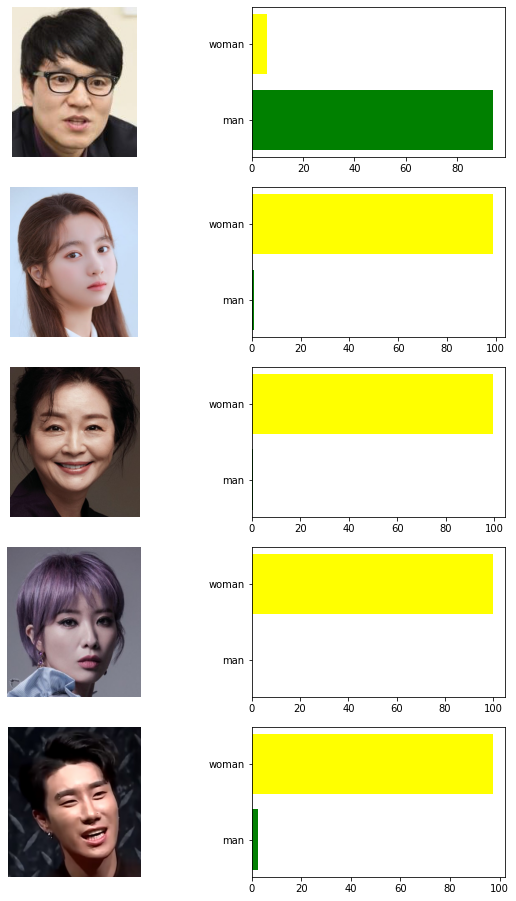

In [ ]:
evaluate_testdata(model_R101)

## ResNet50V2

### Modeling

In [ ]:
#import ResNet50V2
from keras.applications import ResNet50V2

conv_base = ResNet50V2(include_top = False,
                     #weights = 'imagenet',
                      input_shape = (200,200,3))

#model define
from keras import models, layers

#CNN-ResNet50V2
model_R50V2 = models.Sequential()
model_R50V2.add(conv_base)

#DNN
model_R50V2.add(layers.Flatten())
model_R50V2.add(layers.Dense(256, activation = 'relu'))
model_R50V2.add(layers.Dropout(0.4))
model_R50V2.add(layers.Dense(1, activation = 'sigmoid'))


model_R50V2.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 49,255,425
Trainable params: 49,209,985
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
##Model Compile
from keras import optimizers

model_R50V2.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

In [ ]:
##Model fit : epoch 조절

%%time

hist_R50V2 = model_R50V2.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
18/18 [==============================] - 28s 1s/step - loss: 0.9830 - accuracy: 0.5756 - val_loss: 0.6663 - val_accuracy: 0.7013
Epoch 2/50
18/18 [==============================] - 20s 1s/step - loss: 0.6613 - accuracy: 0.7077 - val_loss: 0.6685 - val_accuracy: 0.7247
Epoch 3/50
18/18 [==============================] - 20s 1s/step - loss: 0.5263 - accuracy: 0.7590 - val_loss: 0.5820 - val_accuracy: 0.7584
Epoch 4/50
18/18 [==============================] - 20s 1s/step - loss: 0.4962 - accuracy: 0.7966 - val_loss: 0.5202 - val_accuracy: 0.7857
Epoch 5/50
18/18 [==============================] - 20s 1s/step - loss: 0.5004 - accuracy: 0.7887 - val_loss: 0.5038 - val_accuracy: 0.7740
Epoch 6/50
18/18 [==============================] - 20s 1s/step - loss: 0.4232 - accuracy: 0.8114 - val_loss: 0.5050 - val_accuracy: 0.7701
Epoch 7/50
18/18 [==============================] - 20s 1s/step - loss: 0.3946 - accuracy: 0.8247 - val_loss: 0.4878 - val_accuracy: 0.7792
Epoch 8/50
18/18 [==

### Evaluation

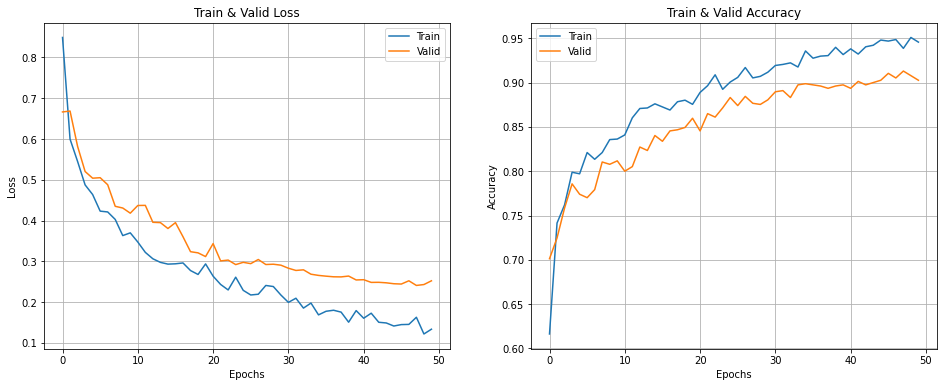

In [ ]:
draw_graph(hist_R50V2)

In [ ]:
loss, acc_R50V2 = model_R50V2.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss:.5f}')

print('\n* Accuracy')
print(f'==> {acc_R50V2:.5f}')


8/8 [==============================] - 1s 164ms/step - loss: 0.2522 - accuracy: 0.9026

* Loss
==> 0.25216

* Accuracy
==> 0.90260


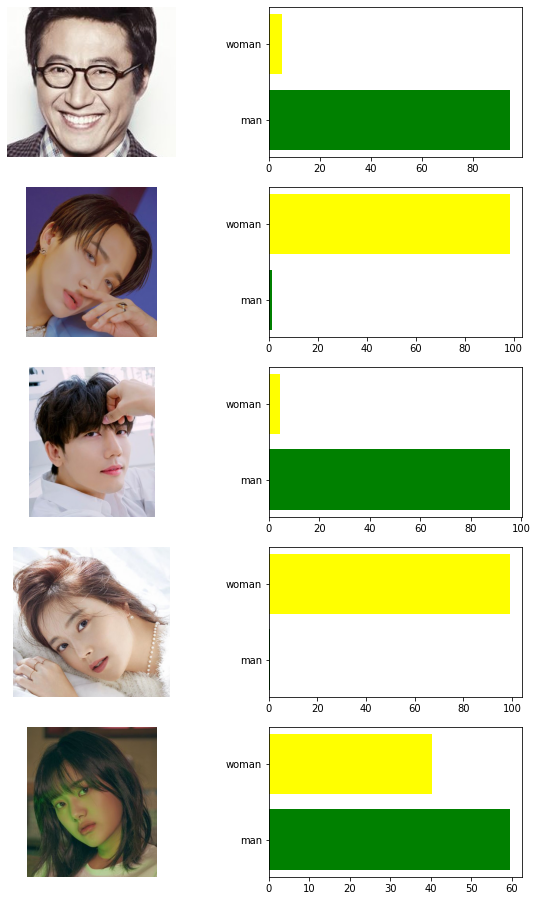

In [ ]:
evaluate_testdata(model_R50V2)

## InceptionV3

### Modeling

In [ ]:
#import InceptionV3 
from keras.applications import InceptionV3

conv_base = InceptionV3(include_top = False,
                       input_shape = (200,200,3))

#model define
from keras import models, layers

#CNN-InceptionV3
model_I = models.Sequential()
model_I.add(conv_base)

#DNN
model_I.add(layers.Flatten())
model_I.add(layers.Dense(256, activation = 'relu'))
model_I.add(layers.Dropout(0.4))
model_I.add(layers.Dense(1, activation = 'sigmoid'))


model_I.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 30,191,905
Trainable params: 30,157,473
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
##Model Compile
from keras import optimizers

model_I.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.00001),
              metrics = ['accuracy'])

In [ ]:
##Model fit : epoch 조절

%%time

hist_I = model_I.fit(train_data,
                 epochs = 50,
                 validation_data = valid_data)

Epoch 1/50
18/18 [==============================] - 30s 1s/step - loss: 0.8178 - accuracy: 0.5200 - val_loss: 0.6922 - val_accuracy: 0.5948
Epoch 2/50
18/18 [==============================] - 19s 1s/step - loss: 0.6563 - accuracy: 0.6349 - val_loss: 0.6211 - val_accuracy: 0.6649
Epoch 3/50
18/18 [==============================] - 19s 1s/step - loss: 0.6231 - accuracy: 0.6604 - val_loss: 0.5847 - val_accuracy: 0.6987
Epoch 4/50
18/18 [==============================] - 19s 1s/step - loss: 0.5634 - accuracy: 0.7078 - val_loss: 0.5618 - val_accuracy: 0.7130
Epoch 5/50
18/18 [==============================] - 19s 1s/step - loss: 0.4908 - accuracy: 0.7722 - val_loss: 0.5286 - val_accuracy: 0.7481
Epoch 6/50
18/18 [==============================] - 19s 1s/step - loss: 0.5133 - accuracy: 0.7428 - val_loss: 0.5083 - val_accuracy: 0.7571
Epoch 7/50
18/18 [==============================] - 19s 1s/step - loss: 0.4918 - accuracy: 0.7698 - val_loss: 0.4949 - val_accuracy: 0.7701
Epoch 8/50
18/18 [==

### Evaluation

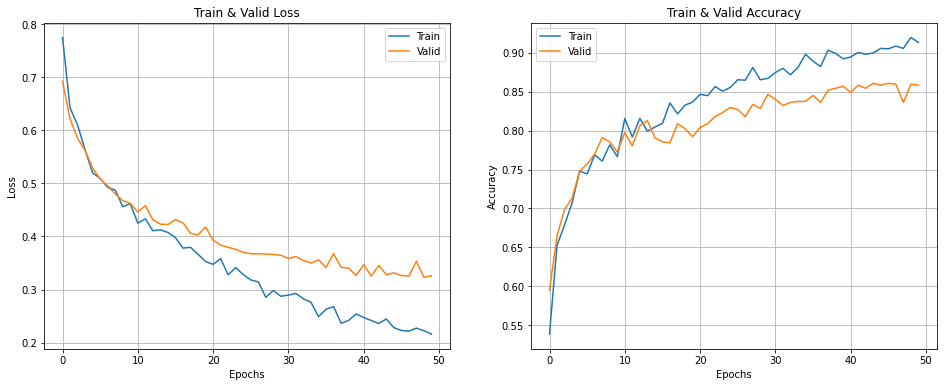

In [ ]:
draw_graph(hist_I)

In [ ]:
loss, acc_I = model_I.evaluate(valid_data)

print('\n* Loss')
print(f'==> {loss:.5f}')

print('\n* Accuracy')
print(f'==> {acc_I:.5f}')


8/8 [==============================] - 1s 159ms/step - loss: 0.3259 - accuracy: 0.8584

* Loss
==> 0.32590

* Accuracy
==> 0.85844


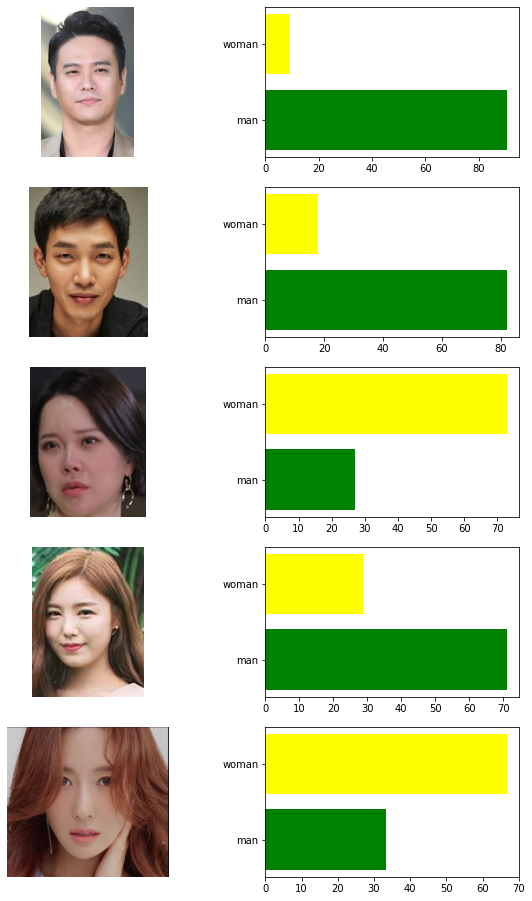

In [ ]:
evaluate_testdata(model_I)

## Result


In [ ]:
import pandas as pd

result = pd.DataFrame(data = {'Name' : ['VGG16','VGG19','ResNet50','ResNet101','ResNet50V2', 'Inception'],
                              'Accuracy' : [acc_V, acc_V19, acc_R, acc_R101, acc_R50V2,, acc_I]})

result = result.sort_values(by = ['Accuracy'], ascending = False)
result

,Name,Accuracy
0,VGG16,0.937662
1,VGG19,0.937662
5,ResNet50V2,0.902597
12,Inception,0.858442
2,ResNet50,0.789610
3,ResNet101,0.685714
4,ResNet152,0.000000
6,ResNet101V2,0.000000
7,ResNet152V2,0.000000
8,DenseNet121,0.000000


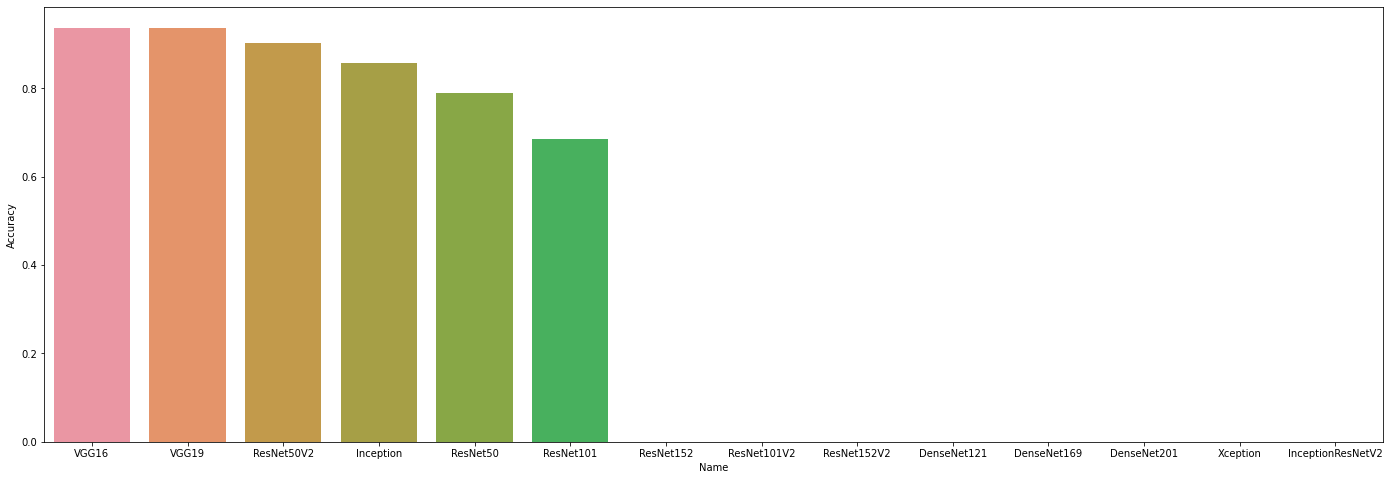

In [ ]:
#Accuracy 순위대로 표시
import seaborn as sns

plt.figure(figsize = (24,8))
sns.barplot(data = result, x = 'Name', y = 'Accuracy')

plt.show()